In [1]:
from make_dummy import MakeDummy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter, ImageDraw

78.53981633974483 1421


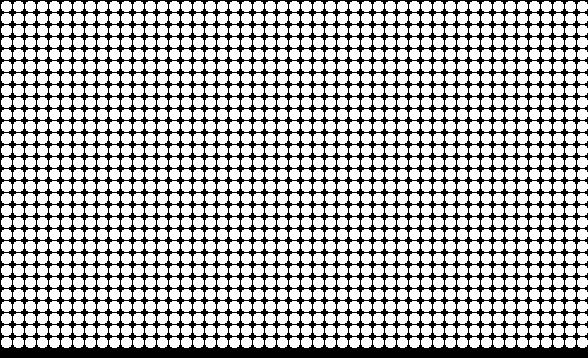

In [2]:
md = MakeDummy(5,1)
print(md.area, md.max_cercle_num)
md.im

In [59]:
class GainParams:
    def __init__(self, img):
        img_origin = img
        #テストなので固定
        self.scale = 200
        self.nm_p_px = self.scale / 141
        self.img_arr = np.array(img_origin)
        self.blur = cv2.GaussianBlur(src = self.img_arr, ksize = (7,7),sigmaX = 0)
        #self.blur = self.img_arr
        
    def binarize(self, scale):
        if scale >= 200:
            img_o = cv2.adaptiveThreshold(self.blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,101,0)
            img_o_debug = img_o.copy()
            kernel = np.ones((1,1),np.uint8)
            img_o_open = cv2.morphologyEx(img_o, cv2.MORPH_OPEN, kernel)
            img_o_open_close = cv2.morphologyEx(img_o_open, cv2.MORPH_CLOSE, kernel)
            self.input_img = img_o_open_close.copy()
            self.input_img = img_o_debug
        if scale < 200:
            ret_o,img_o = cv2.threshold(self.blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((3,3),np.uint8)
            img_o_open = cv2.morphologyEx(img_o, cv2.MORPH_OPEN, kernel)
            img_o_open_close = cv2.morphologyEx(img_o_open, cv2.MORPH_CLOSE, kernel)
            self.input_img  = img_o_open_close.copy()

In [65]:
pic_path = "../picture/1-2Fe62Pt38_RTA(720)/1-2Fe62Pt38_RTA(720)06.TIF"
actual_img = Image.open(pic_path).convert('L')
actual_img = Image.fromarray(np.array(actual_img)[70:428])

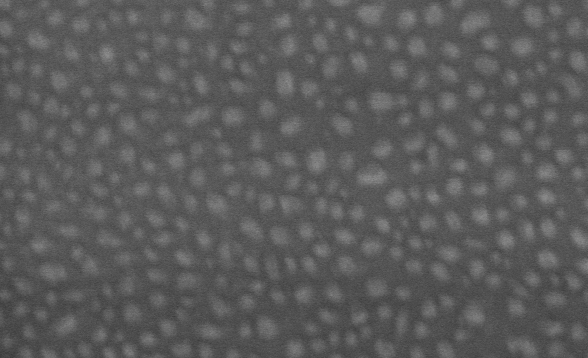

In [66]:
actual_img

In [67]:
gp_actual = GainParams(actual_img)

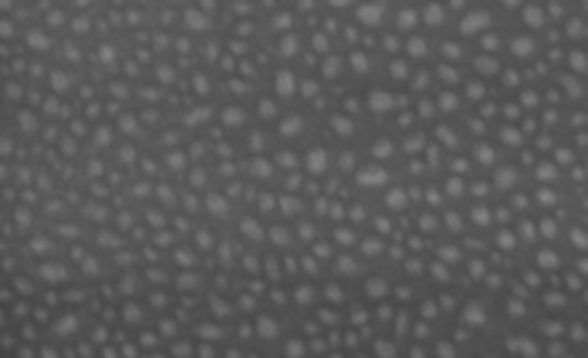

In [68]:
gp = GainParams(md.im)
pil_img = Image.fromarray(gp_actual.blur)
pil_img

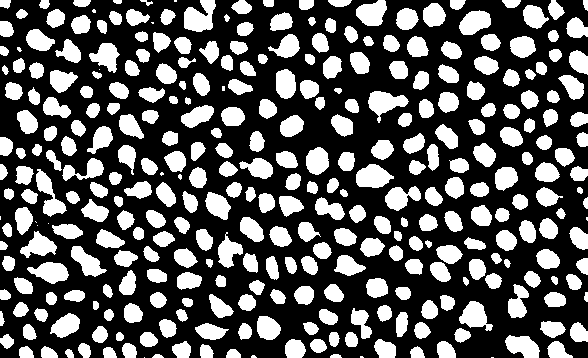

In [69]:
gp_actual.binarize(200)
pil_img = Image.fromarray(gp_actual.input_img)
pil_img

In [91]:
gp.binarize(100)

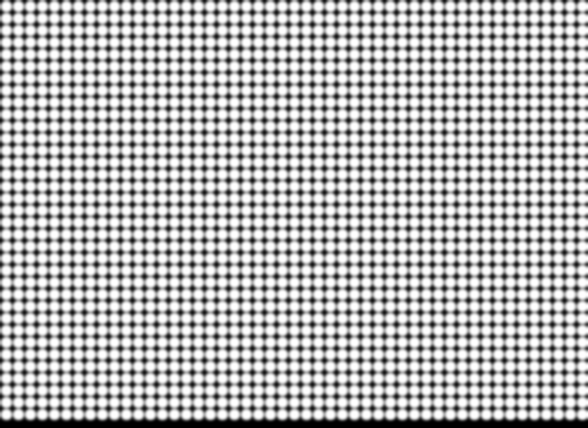

In [95]:
pil_img = Image.fromarray(gp.blur)
pil_img

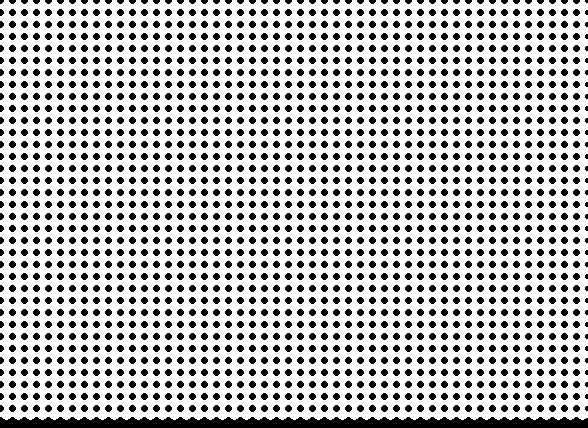

In [94]:
pil_img = Image.fromarray(gp.input_img)
pil_img

In [85]:
def calculate_return_list(img):

    img_origin = img

    #単位を求める'(nm/px)141は点の端から端まで
    scale = 200
    nm_p_px = scale/151
    img_arr = np.array(img_origin)
    img_arr = img_arr[70:428]
    blur = cv2.GaussianBlur(src = img_arr, ksize = (7,7),sigmaX = 0)

    if scale >= 200:
        img_o = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,101,0)
        kernel = np.ones((2,2),np.uint8)
        img_o_open = cv2.morphologyEx(img_o, cv2.MORPH_OPEN, kernel)
        img_o_open_close = cv2.morphologyEx(img_o_open, cv2.MORPH_CLOSE, kernel)
        input_img  = img_o_open_close.copy()
    if scale < 200:
        ret_o,img_o = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        kernel = np.ones((3,3),np.uint8)
        img_o_open = cv2.morphologyEx(img_o, cv2.MORPH_OPEN, kernel)
        img_o_open_close = cv2.morphologyEx(img_o_open, cv2.MORPH_CLOSE, kernel)
        input_img  = img_o_open_close.copy()


    cnt, _ = cv2.findContours(input_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_cnt = cv2.drawContours(input_img, cnt, -1, (25,25,0), 2)



    #面積、円形度、等価直径を求める。
    Areas = []
    Circularities = []
    Eq_diameters = []

    return_hist = []

    zero = 0
    for i in cnt:
        #面積(px*px)
        area = cv2.contourArea(i)
        if scale < 200 and area < 10:
            zero += 1
            continue

        if scale >= 200 and area == 0 :
            zero += 1
            continue
        Areas.append(area)

        #円形度
        arc = cv2.arcLength(i, True)
        circularity = 4 * np.pi * area / (arc * arc)
        Circularities.append(circularity)

        #等価直径(px)
        eq_diameter = np.sqrt(4*area/np.pi)
        Eq_diameters.append(eq_diameter)

    Areas1 = np.array(Areas)*nm_p_px**2
    Eq_diameters1 = np.array(Eq_diameters)*nm_p_px

    a =8
    fig_hist = plt.figure(figsize=(8,2.5))
    hist1 = fig_hist.add_subplot(1,3,1)
    hist1.set_title("Areas (nm^2)",fontsize=a)
    hist1.hist(Areas1, bins=25, range=(0,Areas1.max()), rwidth=0.7)
    hist1.tick_params(labelsize=a-2)

    hist2 = fig_hist.add_subplot(1,3,2)
    hist2.set_title("Circularity",fontsize=a)
    hist2.hist(Circularities, bins=25, range=(0.5,1), rwidth=0.7)
    hist2.tick_params(labelsize=a-2)

    hist3 = fig_hist.add_subplot(1,3,3)
    hist3.set_title("Equal Diameters (nm)",fontsize=a)
    hist3.hist(Eq_diameters1, bins=25, range=(0.0, Eq_diameters1.max()), rwidth=0.7)
    hist3.tick_params(labelsize=a-2)

    n_particle = len(Areas1)
    filling_rate = np.array(Areas).sum()/(img_arr.shape[0]*img_arr.shape[1])
    areas_average = np.array(Areas1).mean()
    areas_var = np.var(np.array(Areas1))
    Circularities_mean = np.array(Circularities).mean()
    Circularities_var = np.var(np.array(Circularities))
    area = np.array(img_origin).shape[0]*np.array(img_origin).shape[1]*nm_p_px**2



    particle_dataframe = pd.DataFrame(np.array([Areas,Circularities,Eq_diameters]).T,columns =  ["Areas","Circularities","Eq_diameters"])


    return_list = [scale,n_particle,filling_rate,areas_average,areas_var,Circularities_mean,Circularities_var,area]
    return np.array(return_list) , [[img_o_open_close],[img_arr]] , fig_hist , particle_dataframe


(array([2.00000000e+02, 5.40000000e+01, 1.20092730e-01, 8.21276520e+02,
        6.01166338e+01, 8.76171919e-01, 6.84218010e-05, 4.41496426e+05]),
 [[array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
  [array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]],
 <Figure size 576x180 with 3 Axes>,
     Areas  Circularities  Eq_diameters
 0   476.0       0.890867     24.618327
 1   472.0       0.883381     24.514670
 2   472.0       0.883381     24.514670
 3   472.0       0.883381     24.514670
 4   472.0       0.883381     24.514670
 5   472.0       0.883381     24.514670
 6   472.0       0.883381     24.514670
 7   472.0     

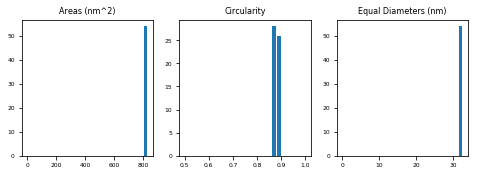

In [37]:
calculate_return_list(md.im)